Formation OpenClassrooms DS-IML

**Projet 2**

Par **Marc Lefèvre**, <marc.lefevre@noos.fr>

## 4ème Partie

# Modèle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

Définissons deux classes, **Produit** et **Repartiteur**, qui vont nous servir à construire des échantillons d'entrainement équilibrés en terme de **labels**.

In [2]:
SEUILS = [15810, 13220, 21010, 31000, 18960]


class Produit() :
    
    def __init__(self, feats_array, rating):
        self.feats_array = feats_array
        self.rating = rating

# Classe servant à créer des échantillons dont les classes seront également fournies.
# Le paramètre "limite" peut servir à fixer le nombre de samples par classe.
# "seuil" peut servir à avoir une distribution de classes précise dans l'échantillon de test.

class Repartiteur() :
    
    def __init__(self, liste_produits, limite=None, seuils=None):
        self.liste_produits = liste_produits
        self.limite = limite
        self.seuils = seuils
        
    def repartition(self) :
        
        liste_a = []
        liste_b = []
        liste_c = []
        liste_d = []
        liste_e = []
        
        for p in self.liste_produits :
            if p.rating == "a" :
                liste_a.append(p)
            if p.rating == "b" :
                liste_b.append(p)
            if p.rating == "c" :
                liste_c.append(p)
            if p.rating == "d" :
                liste_d.append(p)
            if p.rating == "e" :
                liste_e.append(p)
        
        if self.limite == None :
            seuil = min(len(liste_a), len(liste_b), len(liste_c), len(liste_d), len(liste_e),)
        else :
            seuil = self.limite
        
        liste_a = liste_a[:seuil]
        liste_b = liste_b[:seuil]
        liste_c = liste_c[:seuil]
        liste_d = liste_d[:seuil]
        liste_e = liste_e[:seuil]
        
        self.liste_produits = liste_a + liste_b + liste_c + liste_d + liste_e
        random.shuffle(self.liste_produits)
        
    def repartition_test(self) :
        
        liste_a = []
        liste_b = []
        liste_c = []
        liste_d = []
        liste_e = []
        
        for p in self.liste_produits :
            if p.rating == "a" :
                liste_a.append(p)
            if p.rating == "b" :
                liste_b.append(p)
            if p.rating == "c" :
                liste_c.append(p)
            if p.rating == "d" :
                liste_d.append(p)
            if p.rating == "e" :
                liste_e.append(p)
        
        liste_a = liste_a[:self.seuils[0]]
        liste_b = liste_b[:self.seuils[1]]
        liste_c = liste_c[:self.seuils[2]]
        liste_d = liste_d[:self.seuils[3]]
        liste_e = liste_e[:self.seuils[4]]
        
        self.liste_produits = liste_a + liste_b + liste_c + liste_d + liste_e
        random.shuffle(self.liste_produits)        
        
        
        
    def get_feats_array(self):
        
        return [p.feats_array for p in self.liste_produits]

    def get_rating(self):
        
        return [p.rating for p in self.liste_produits]

Récupération des données

In [3]:
df = pd.read_csv("Data/df_mod.csv")
df.shape

(1429501, 28)

On ne garde dans notre dataframe que les données **bien renseignées** avec lesquelles nous allons travailler.

In [4]:
liste_drop = ['code', 'url', 'countries_en', 'product_name', 'brands', 'allergens', 'additives_en', 
              'nova_group', 'nutriscore_score', 'trans-fat_100g', 'cholesterol_100g', 
              'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 
              'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', "fiber_100g", 
              "additives_n"]

df = df.drop(liste_drop, axis = 1)
df = df.dropna(axis = 0)
df.shape

(540620, 9)

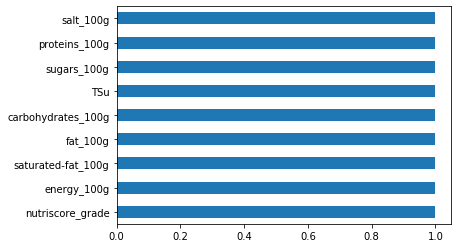

In [5]:
df.notnull().mean().plot.barh()

Liste des variables choisies pour notre modèle :

In [9]:
feats = ["energy_100g", "fat_100g", "saturated-fat_100g", "TSu", 'proteins_100g', "salt_100g" , 
         "sugars_100g"]

In [6]:
df.to_csv("Data/data.csv", index = False)

## Préparation des données

In [7]:
data = pd.read_csv("Data/data.csv")

In [10]:
# itération dans la DF pour créer notre liste de produits

produits = []

for i in data.index :
    
    features = []
    
    for feat in feats :
        features.append(data[feat][i])
    
    prod = Produit(features, data["nutriscore_grade"][i])
    produits.append(prod)
    
# Echantillonage train / test

train, test = train_test_split(produits, test_size = 0.2, random_state = 32)

# echantillonage features / labels

rep1 = Repartiteur(train)
rep1.repartition()

train_X = rep1.get_feats_array()
train_y = rep1.get_rating()

rep2 = Repartiteur(test)
#rep2.repartition()

test_X = rep2.get_feats_array()
test_y = rep2.get_rating()

In [11]:
print(len(train))
print(len(test))
print(len(train_X))
print(len(train_y))
print(len(test_X))
print(len(test_y))

432496
108124
270300
270300
108124
108124


# Modèles

Résultats avec échantillon de test uniforme en terme de classes

### **Random Forest Classifier**

In [13]:
results_rfc = []
methodes = ["gini", "entropy"]
esti = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

for met in methodes :
    for n in esti :
        rfc = RandomForestClassifier(criterion = met, n_estimators = 100)
        rfc.fit(train_X, train_y)
        pred_rfc = rfc.predict(test_X)
        print(f"Pour critère = {met} et n_esti = {n},\
              l'accuracy est : {accuracy_score(test_y, pred_rfc)}")
        f1 = f1_score(test_y, pred_rfc, average = None, labels=["a", "b", "c", "d", "e"])
        print(f"Le F1_Score est : {f1}")
        print()
        results_rfc.append((met, n, float(accuracy_score(test_y, pred_rfc))))

Pour critère = gini et n_esti = 10, l'accuracy est : 0.848294550701047
Le F1_Score est : [0.86693999 0.7494943  0.79257035 0.88153085 0.90568401]

Pour critère = gini et n_esti = 20, l'accuracy est : 0.8485720099145425
Le F1_Score est : [0.86615706 0.7518936  0.79356592 0.88152124 0.9048304 ]

Pour critère = gini et n_esti = 30, l'accuracy est : 0.8487199881617402
Le F1_Score est : [0.86578797 0.75292611 0.79372846 0.88162577 0.9050007 ]

Pour critère = gini et n_esti = 40, l'accuracy est : 0.848858717768488
Le F1_Score est : [0.86626689 0.75307676 0.79398302 0.88175904 0.90480941]

Pour critère = gini et n_esti = 50, l'accuracy est : 0.8479800969257519
Le F1_Score est : [0.86528854 0.75094862 0.79298683 0.88152342 0.90409688]

Pour critère = gini et n_esti = 60, l'accuracy est : 0.8485627612740927
Le F1_Score est : [0.86576065 0.75128779 0.79411961 0.88174551 0.90481606]

Pour critère = gini et n_esti = 70, l'accuracy est : 0.8487754800044394
Le F1_Score est : [0.86630678 0.75308072 0

In [14]:
resa = np.array(results_rfc)
res_rfc = pd.DataFrame(resa, columns=["type", "n", "acc"])

def to_int(v):
    v = int(v)
    return v

def to_float(v):
    v = float(v)
    return v

res_rfc.n = res_rfc.n.map(to_int)
res_rfc.acc = res_rfc.acc.map(to_float)

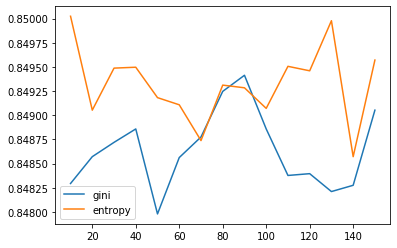

La meilleure performance et ses paramètres correspondants sont :


,type,n,acc
15,entropy,10,0.850024


In [15]:
plt.figure()
plt.plot(res_rfc[res_rfc.type=="gini"]["n"],res_rfc[res_rfc.type=="gini"]["acc"], label = "gini")
plt.plot(res_rfc[res_rfc.type=="entropy"]["n"],res_rfc[res_rfc.type=="entropy"]["acc"], 
         label = "entropy")
plt.legend()
plt.show()
print("La meilleure performance et ses paramètres correspondants sont :")
res_rfc.sort_values("acc", ascending = False).head(1)

### Matrice de confusion du modèle

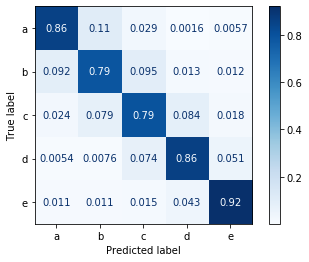

In [60]:
classes = sorted((set(test_y)))

conf_matrix = plot_confusion_matrix(model_rfc, test_X, test_y, display_labels = classes, 
                                    cmap=plt.cm.Blues, normalize = "true")

### Sauvegarde du modèle

In [62]:
model_rfc = RandomForestClassifier(criterion = "entropy", n_estimators = 130)
model_rfc.fit(train_X, train_y)

pickle_out = open("Data/model_rfc.pickle", "wb")
pickle.dump(model_rfc, pickle_out)
pickle_out.close()

# Mise à jour du dataset

Récupération des données et du modèle

In [6]:
df = pd.read_csv("Data/df_mod.csv")
modele = pickle.load(open("Data/model_rfc.pickle", "rb"))

Prédictions et MAJ du dataset

In [7]:
feats = ["energy_100g", "fat_100g", "saturated-fat_100g", "TSu", 'proteins_100g', "salt_100g" , 
         "sugars_100g"]

# soit df_ac la partie de df ou le nutriscore_grade est nul
df_ac = df[df.nutriscore_grade.isnull()]

# réduction du dataset telle que les "feats" soient renseignés
for col in feats :
    df_ac = df_ac[df_ac[col].notnull()]

# définition de X
X = df_ac[feats]

# prédictions
df_ac["nutriscore_grade"] = modele.predict(X)

# on complète le dataset original avec les valeurs prédites
df.loc[df["nutriscore_grade"].isnull(), "nutriscore_grade"] = df_ac.nutriscore_grade

Maintenant que nous avons complété ce que l'on souhaitait, il est temps d'appliquer **certaines restrictions** qu'on peut souhaiter avant de passer à la phase "moteur de recommandation".

## Restriction du dataset à la sphère francophone

Avant de passer à la suite, nous allons réduire le dataset aux produits de la sphère francophone.

In [8]:
liste_fr = ["France", "French", "french", "france", "français", "Français", "française", "Française", 
            "FR", "fr", "Fr", "Belgique", "belgique", "belgium", "Belgium", "belge", "Suisse", 
            "suisse", "Frankreich", "frankreich", "francais", "francaise", "Francia", "francia"]

# les valeurs "countries_en" avec une expression de la liste seront classées "francophone"
def mapping_fr(value):
    
    for val in re.findall(r"[\w']+", str(value)): # utilisation d'une RE   
        if val in liste_fr :
            return "francophone"
    
    return value

Réduction du dataset à la sphère francophone

In [10]:
df["countries_en"] = df["countries_en"].map(mapping_fr)
df = df[df["countries_en"] == "francophone"]
df = df.drop(["countries_en"], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 743271 entries, 0 to 1429500
Data columns (total 27 columns):
code                                       743271 non-null object
url                                        743271 non-null object
product_name                               723409 non-null object
brands                                     403917 non-null object
allergens                                  81501 non-null object
nova_group                                 191157 non-null float64
additives_en                               123239 non-null object
nutriscore_score                           247410 non-null float64
nutriscore_grade                           541853 non-null object
additives_n                                231382 non-null float64
ingredients_from_palm_oil_n                231382 non-null float64
ingredients_that_may_be_from_palm_oil_n    231382 non-null float64
energy_100g                                587584 non-null float64
saturated-fat_100g       

Sauvegarde du dataset aux "nutriscore_grade" complétés et réduit à la sphère francophone.

In [12]:
# sauvegarde sous le nom "df_mot"
df.to_csv("Data/df_mot.csv", index = False)

Fin de la **4ème partie**.